<a href="https://colab.research.google.com/github/rsoaresp/docs/blob/master/mean_variance_online_calculations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Online calculation of the mean and variance

We show how to calculate, and why we need it, mean and variance for a stream of numbers.

The general form os the arithmetic mean is well know to everybody, from the good and old school times, where we learnt that the mean $\bar{x}_{n}$ of a set of $n$ number $x_1, x_2, ..., x_n$ is

$\bar{x}_{n} = \frac{x_1 + x_2 + ... + x_n}{n}$.

Suppose we calculate the average of one billion numbers. Then someone gives you a new number and asks the result of the new average. Do you have to do the sum of a billion number all over again? This is surely a waste of time and there must be a better way to do this.

Actually, we can rewrite the equation separting the newest contribution $x_{n}$ from the previous ones as

$\bar{x}_{n} = \frac{x_1 + x_2 + ... + x_{n-1}}{n} \times \frac{n-1}{n-1} + \frac{x_n}{n}$,

which leads to the formula

$\bar{x}_{n} = \bar{x}_{n-1} \frac{n-1}{n} + \frac{x_n}{n}$.

The result above is all we wished for, but let's move a little bit more and write it as

$\bar{x}_{n} = \bar{x}_{n-1} + \frac{1}{n}(x_n - \bar{x}_{n-1})$

We see that the new average is just equal to the previous one, calculate with our first billion numbers, plus a term that is the difference between the new entry and the already know mean, divided by 1000000001 (the number $n$ of numbers). Look how pretty and simple it is!

The coolest thing about this _online_ calculation is that it can be extended, in the same spirit of what we did for the arithmetic mean, to the generalized mean, which covers the harmonic, geometric and other cases by variation of a single parameter. It's defined as: 

$\bar{x}_{n} = \left( \frac{1}{n}\sum_{i=1}^{n} x_{i}^{m} \right)^{(1/m)}$,

where $m$ is a parameter ($m=1$ leads to the arithmetic mean, for instance). The strategy is similar to what we did earlier, separating the newest contribution of the $x_n$ term and writing the previous ones as $\bar{x}_{n-1}$, leading us into

$\bar{x}_{n}^{m} = \bar{x}_{n-1}^{m} + \frac{1}{n}(x_n^{m} - \bar{x}_{n-1}^{m})$.

In a even more general scenery, we can write an _online_ equation for means calculated as

$\bar{x}_{n} = f^{-1}\left( \frac{1}{n} \sum_{i=1}^{n} f(x_i) \right)$,

$f\left(\bar{x}_{n}\right) = f \left(\bar{x}_{n-1}\right) + \frac{1}{n}(f\left(x_n\right) - f\left(\bar{x}_{n-1}\right))$

Let's move on and do some numerical exercises to check what we've saying!


In [1]:
import numpy as np
from typing import Callable

In [41]:
def online_averager(averager_type: str, **kwargs) -> Callable:
    
    n, mean = 0, 0
    m = kwargs.get('m', 1)
    
    def arithmetic_averager(new_value: float) -> float:
        nonlocal n, mean
        n = n + 1
        mean = mean + (new_value - mean)/n
        return mean
    
    def generalized_averager(new_value: float) -> float:
        nonlocal n, mean        
        n = n + 1
        mean = (mean**m + (new_value**m - mean**m)/n)**(1/m)
        return mean
        
    if averager_type == 'arithmetic':
        return arithmetic_averager
    elif averager_type == 'generalized':
        return generalized_averager

In [3]:
avg = online_averager('arithmetic')

numbers = [1,2,3,4,5]
for pos, num in enumerate(numbers):
    print(avg(num), np.mean(numbers[0:1+pos]))

1.0 1.0
1.5 1.5
2.0 2.0
2.5 2.5
3.0 3.0


In [56]:
avg = online_averager('generalized', m=3)

numbers = [1,2,3,4,5]
for pos, num in enumerate(numbers):
    print(avg(num))

1.0
1.6509636244473134
2.2894284851066637
2.924017738212866
3.5568933044900626


In [5]:
np.mean([i**3 for i in numbers])**(1/3)

3.5568933044900626

The calculations above work well for the case of a stationary process, a process where its properties doesn't change too much during its lifetime. For example, if our set of numbers consist of the height of human beings, it'll be a collection of numbers give by, roughly, a normal distribution that will keep its mean and variance constant trough a long time. On the other hand, many processes have abrupt changes where it's no longer meaninful to keep numbers from a long time ago in the calculation of the mean, since by use of the mean we are trying to give a concise description of the distribution.

We must, somehow, erase the influence of the past numbers.

We can build the following sequence, with $0 \le \alpha \le 1$.

$\bar{x}_n = \left( 1 - \alpha \right) \bar{x}_{n-1} + \alpha x_{n} = \bar{x}_{n-1} + \alpha \left( x_{n} - \bar{x}_{n-1} \right)$ 

that is exactly what we had for the arithmetic mean, but with $1/n$ replace by $\alpha$. The meaning of the above equation is that we are forgeting the past with weight $(1-\alpha)$ and taking the present with $\alpha$. On general, we keep on saying that this is a _mean_ because the sum of the coefficients multiplying the $x$ sum up to one.

Another advantage of writing the equation on the _online_ form is that we can get their non stationary versions. It's not clear how do adapt $\bar{x}_{n} = f^{-1}\left( \frac{1}{n} \sum_{i=1}^{n} f(x_i) \right)$ when the process generating the values $x$ is not stationary. However, from  $f\left(\bar{x}_{n}\right) = f \left(\bar{x}_{n-1}\right) + \frac{1}{n}(f\left(x_n\right) - f\left(\bar{x}_{n-1}\right))$ we can move on and replace $n^{-1}$ by $\alpha$.

Let's test some of our claims above

In [6]:
import matplotlib.pylab as plt

Let's generate a time series of positive numbers from two normal distributions with different means and stacking both

In [61]:
non_stationary_ts = np.hstack([np.random.normal(loc=5, size = 1000), np.random.normal(loc=10, size = 1000)])

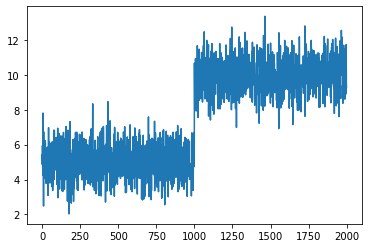

In [62]:
plt.plot(non_stationary_ts)

In [63]:
def online_averager_ns(averager_type: str, alpha: float, **kwargs) -> Callable:
    
    n, mean = 0, 0
    m = kwargs.get('m', 1)
    
    def arithmetic_averager(new_value: float) -> float:
        nonlocal n, mean
        n = n + 1
        mean = mean + alpha*(new_value - mean)
        return mean
    
    def generalized_averager(new_value: float) -> float:
        nonlocal n, mean        
        n = n + 1
        mean = (mean**m + alpha*(new_value**m - mean**m))**(1/m)
        return mean
        
    if averager_type == 'arithmetic':
        return arithmetic_averager
    elif averager_type == 'generalized':
        return generalized_averager

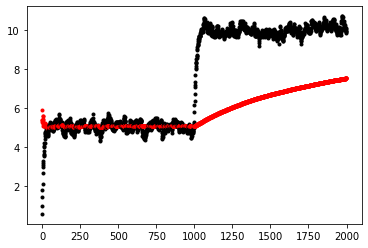

In [69]:
arithmetic_ns = online_averager_ns('arithmetic', 0.1)
arithmetic = online_averager('arithmetic')
for pos, num in enumerate(non_stationary_ts):
    plt.plot(pos, arithmetic(num), 'r.')
    plt.plot(pos, arithmetic_ns(num), 'k.')

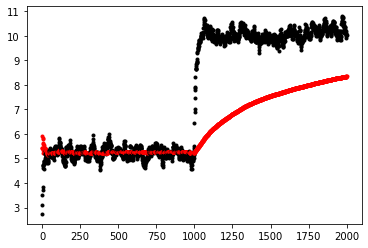

In [70]:
generalized_ns = online_averager_ns('generalized', 0.1, m=3)
generalized = online_averager('generalized', m=3)
for pos, num in enumerate(non_stationary_ts):
    plt.plot(pos, generalized(num), 'r.')
    plt.plot(pos, generalized_ns(num), 'k.')